## SIMP with filter and penalization

### Import libraries

In [ ]:
# Topology optimization code
from __future__ import division
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as pltddd
import sympy as sp
from sympy import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### Task 1 - derive stiffness matrix
In the following function, derive the stiffness matrix per element
$$\mathbf{K} = \int_{x,y} \mathbf{B}^\mathrm{T} \mathbf{C} \mathbf{B} \, dxdy$$
by first deriving the matrix for the shape function $\mathbf{B}$
Assumge plane stress condition and thickness is 1

In [ ]:
''' Derive and calculate the stiffness matrix
    input:
        p - input parameters
    output:
        K - a numerical element wise stiffness matrix
'''
def lk(p):

    # Define symbolic variables
    a, b, x_1, x_2, nu, E = symbols("a b x_1 x_2 nu E ") # x_1 & x_2 are Local coordinates within the element

    # Plane stress stiffness matrix for a rectangular element
    # Define the shape functions for a quadrilateral element
    N1 = (1/4)*(1-x_1)*(1-x_2)
    N2 = (1/4)*(1+x_1)*(1-x_2)
    N3 = (1/4)*(1+x_1)*(1+x_2)
    N4 = (1/4)*(1-x_1)*(1+x_2)

    # Define the derivative of shape functions in local coordinates
    dN1x1 = diff(N1, x_1)
    dN1x2 = diff(N1, x_2)
    dN2x1 = diff(N2, x_1)
    dN2x2 = diff(N2, x_2)
    dN3x1 = diff(N3, x_1)
    dN3x2 = diff(N3, x_2)
    dN4x1 = diff(N4, x_1)
    dN4x2 = diff(N4, x_2)

    # Assemble the B matrix (strain-displacement matrix)
    B = Matrix([[dN1x1, 0, dN2x1, 0, dN3x1, 0, dN4x1, 0],
                [0, dN1x2, 0, dN2x2, 0, dN3x2, 0, dN4x2],
                [dN1x2, dN1x1, dN2x2, dN2x1, dN3x2, dN3x1, dN4x2, dN4x1]])

    # Define the material matrix for plane stress
    C = (E / (1 - nu**2)) * Matrix([[1, nu, 0],
                                    [nu, 1, 0],
                                    [0, 0, (1 - nu) / 2]])

    # Integrate B.T * D * B over the element to get stiffness matrix
    K_sym = integrate(integrate(B.T * C * B, (x_1, -a, a)), (x_2, -b, b))

    # Convert symbolic expression to numerical function
    K = lambdify((E, nu, a, b), K_sym, 'numpy')

    return K

### Task 2 - local / global mapping

In [ ]:
''' generate mapping matrix between local and global matrix
    input:
        p - input parameters
    output:
        edofMat - element dof matrix
'''
def edofMatFun(p):
    nx = p['nx']  # number of elements in the x-direction
    ny = p['ny']  # number of elements in the y-direction
    edofMat = np.zeros((nx * ny, 8), dtype=int)

    # Type your code here

    # Assign DOFs to each element
    for i in range(nx):
        for j in range(ny):
            # Element number - traverse columns first, then rows
            elem = j + i * ny

            # Calculate global node numbers for the current element
            # Nodes are numbered column-wise from bottom to top
            n1 = i * (ny + 1) + j
            n2 = n1 + ny + 1
            n3 = n2 + 1
            n4 = n1 + 1

            # Global DOFs for the current element
            # DOFs are ordered as: [bottom-left, bottom-right, top-right, top-left]
            edofMat[elem, :] = [2 * n1, 2 * n1 + 1, 2 * n2, 2 * n2 + 1, 2 * n3, 2 * n3 + 1, 2 * n4, 2 * n4 + 1]

    # Type above

    return edofMat


### Task 3 - Finite element solver

In [ ]:
''' Finite element solver
    solving for displacement based on updated stiffness
    a new global stiffness matrix is generated at every iteration
    by looping through each element in turn
    input:
        x  - current iteration optimization density
        p - input parameters
        KE - element wise stiffness
        F - DOF force array
        freeDOF - free degrees of freedom
        fixedDOF - fixed degrees of freedom
    output:
        U - calculated displacement
'''
def FE(x, p, KE, edofMat, F, freeDOF, fixedDOF):
    ndof = 2 * (p['nx'] + 1) * (p['ny'] + 1)  # Total number of degrees of freedom

    # Initialize the global stiffness matrix and displacement vector
    K = np.zeros([ndof, ndof])
    U = np.zeros([ndof])

    # Loop through each element
    for elx in range(p['nx']):
        for ely in range(p['ny']):

            # Get the row from the edofMat
            edof = edofMat[ely + elx * p['ny'], :]

            # Create index array
            edofId = np.ix_(edof, edof)

            # Use elx and ely to index x for the current element's density
            x_e = x[ely, elx]

            # Update the stiffness matrix with the current iteration optimization density
            K[edofId] = K[edofId] + x_e ** p['penal'] * (p['E'] - p['Emin']) * KE

    # Apply boundary conditions
    free = np.setdiff1d(np.arange(ndof), fixedDOF)

    # Solve for displacements
    #U[free] = np.linalg.solve(K[np.ix_(free, free)], F[free])
    U[free] = np.linalg.solve(K[np.ix_(free, free)], F[free]).flatten()


    return U


### Task 4 - Sensitivity filter

In [ ]:
''' sensitivity filter
    input:
        x  - current iteration optimization density
        dc - gradient of compliance
        p - input parameters
    output:
        dcn - updated gradient of compliance
'''
def sFilter(x, dc, p):
    nx, ny, rmin = p['nx'], p['ny'], p['rmin']  # Number of elements in x and y direction

    dcn = np.zeros([ny, nx])  # Initialize the updated gradient of compliance

    # Loop through each element in the grid
    for i in range(ny):
        for j in range(nx):
            sum_Hf = 0.0
            dcnew = 0.0

            # Loop through each element within the filter radius
            for k in range(max(i - int(np.floor(rmin)), 0), min(i + int(np.ceil(rmin)), ny)):
                for l in range(max(j - int(np.floor(rmin)), 0), min(j + int(np.ceil(rmin)), nx)):

                    # Calculate distance between element (i, j) and element (k, l)
                    dist = np.sqrt((i - k)**2 + (j - l)**2)

                    # Calculate weight factor based on distance
                    weight = max(0, rmin - dist)

                    # Accumulate the weighted compliance gradient
                    dcnew += weight * x[k, l] * dc[k, l]

                    # Accumulate the weight factor
                    sum_Hf += weight * x[k, l]

            # Update the compliance gradient for element (i, j)
            if sum_Hf > 0:
                dcn[i, j] = dcnew / sum_Hf

    return dcn

### Task 5 - Optimality criteria

In [ ]:
''' Optimality criteria
    input:
        x  - current iteration optimization density
        dc - gradient of compliance
        p - input parameters
    output:
        xnew - updated x
'''
def oc(x, dc, p):

    l1, l2, move, ny, nx, volfrac, Emax, Emin, penal = 0, 1e9, 0.2, p['ny'], p['nx'], p['volfrac'], p['Emax'], p['Emin'], p['penal']

    while l2 - l1 > 1e-4:
        lmid = 0.5 * (l1 + l2)
        be = x * np.sqrt(-dc / lmid)  # Size of this is [ny, nx]

        xnew = x.copy()
        for i in range(ny):
            for j in range(nx):
                if be[i, j] <= max(Emin, x[i, j] - move):
                    xnew[i, j] = max(Emin, x[i, j] - move)
                elif be[i, j] >= min(Emax, x[i, j] + move):
                    xnew[i, j] = min(Emax, x[i, j] + move)
                else:
                    xnew[i, j] = be[i, j]

        if np.sum(xnew) - volfrac * nx * ny > 0:
            l1 = lmid
        else:
            l2 = lmid

    return xnew

### Task 6 - SIMP Method for Topology Optimization

In [ ]:
''' Function to execute topology optimization
    input:
        p - input parameters
        case - load case
    output:
        xnew - updated x
'''
def TOsolve(p, case):
    # Initialization
    nx, ny, volfrac, rmin, penal, Emax, Emin = p['nx'], p['ny'], p['volfrac'], p['rmin'], p['penal'], p['Emax'], p['Emin']

    # Initialize based on case
    case_data = cases[case]
    fixed_dof = case_data['fixed_dof']
    force_dof = case_data['force_dof']
    force_val = case_data['force_val']

    x = volfrac * np.ones((ny, nx))
    dc = np.zeros((ny, nx))
    ndof = 2 * (nx + 1) * (ny + 1)

    #Use p and get K_function
    K_function = lk(p)

    # Specify the values of E, nu, a, and b for which you want to evaluate K
    E_value = 1.0  # Example Young's modulus in Pascals
    nu_value = 0.4  # Example Poisson's ratio
    a_value = 1  # Example element dimension in x-direction (meters)
    b_value = 1  # Example element dimension in y-direction (meters)

    # Evaluate K for the specified values
    K_matrix = K_function(E_value, nu_value, a_value, b_value)

    # Use p and get edofMat
    edofMat = edofMatFun(p)

    # Define global force vector F
    F = np.zeros((ndof, 1))
    for dof in force_dof:
        F[dof] = force_val

    # Define freeDOF and fixedDOF based on the case
    freeDOF = np.setdiff1d(np.arange(ndof), fixed_dof)
    #Fixed_dof already specified used generate code from professor

    # Loop parameters
    max_iteration = p['max_iteration']
    change = 1
    counter = 0
    xList = []

    data = []  # Initialize an empty list to store data for each iteration


    while change > 0.01 and counter < max_iteration:
        counter += 1
        # Finite Element Analysis
        U = FE(x, p, K_matrix, edofMat, F, freeDOF, fixed_dof)

        # Compliance and sensitivity analysis
        c = 0

        for elx in range(nx):
            for ely in range(ny):
                el = ely + elx * ny
                ue = U[edofMat[el, :]]
                ce = np.dot(ue.T, np.dot(K_matrix, ue))
                c += (Emin + x[ely, elx] ** penal * (Emax - Emin)) * ce
                dc[ely, elx] = -penal * x[ely, elx] ** (penal - 1) * ce

        # Filtering of sensitivities
        dc = sFilter(x, dc, p)  # Assuming sFilter function is defined

        # Optimality criteria update of design variables
        xnew = oc(x, dc, p)  # Assuming oc function is defined

        # Update change and design variables
        change = np.max(np.abs(xnew - x))
        x = xnew
        xList.append(x.copy())

        # Optional: Print results for each iteration
        print(f"Iteration: {counter}, Change: {change}, Compliance: {c}")

        # Collect data for this iteration
        data.append({'iteration': counter, 'change': change, 'compliance': c, 'x': x.copy()})

    # Create DataFrame from collected data
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv("topology_optimization_results.csv", index=False)

    # Type above

    return xList, df  # xList is a list of optimized structure at every iteration

### Code execution

In [ ]:
# Input parameters #     # Something is wrong in code, need to change codeand match variables


p = dict()

p['nx']      = int(70)  # number of elem in the x direction
p['ny']      = int(35)  # number of elem in the y direction
p['volfrac'] = 0.3  # Target volume fraction
p['rmin']    = 1.5 # radius of filter
p['penal']   = 3. # penalization exponent
p['nu']      = 0.4 # Poisson's ratio
p['Emax']    = 1 # Maximum youngs modulus
p['Emin']    = 1e-4 # Minimum youngs modulus
p['max_iteration'] = 50  # Maximum number of iterations for the optimization
p['E'] = 1


cases = {    # for 70, 35
    0: {
        'fixed_dof': [0,1,2,3,4,5,6,7,8,9,10,11,60,61,62,63,64,65,66,67,68,69,70,71],
        'force_dof': [5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081],
        'force_val': -0.1414
    },

    1: {     # for 70, 35
        'fixed_dof': [0,1,72,73,144,145,216,217,288,289,360,361,432,433,504,505,4536,4537,4608,4609,4680,4681,4752,4753,4824,4825,4896,4897,4968,4969,5040,5041],
        'force_dof': [720,721,793,865,937,1009,1081,1153,1225,1297,1369,1441,1513,1585,1657,1729,1801,1873,1945,2017,2089,2161,2233,2305,2377,2449,2521,2593,2665,
                      2737,2809,2881,2953,3025,3097,3169,3241,3313,3385,3457,3529,3601,3673,3745,3817,3889,3961,4033,4105,4177,4249,4321],
        'force_val': -0.02
    },

}

# Assign load case
case = 0 # or 1  (for x70 & y35, for other values , should change a,b)

xList, df = TOsolve (p, case)

Iteration: 1, Change: 0.2, Compliance: 1195.3084693639566
Iteration: 2, Change: 0.20000000000000007, Compliance: 569.3536329341398
Iteration: 3, Change: 0.20000000000000007, Compliance: 401.97934677122316
Iteration: 4, Change: 0.20000000000000007, Compliance: 309.72548870147205
Iteration: 5, Change: 0.20000000000000007, Compliance: 251.83166907390654
Iteration: 6, Change: 0.20000000000000007, Compliance: 212.08170568205298
Iteration: 7, Change: 0.20000000000000007, Compliance: 178.94428402519193
Iteration: 8, Change: 0.20000000000000007, Compliance: 152.45776952724287
Iteration: 9, Change: 0.20000000000000007, Compliance: 131.90701800065784
Iteration: 10, Change: 0.20000000000000007, Compliance: 116.76499893163881
Iteration: 11, Change: 0.20000000000000007, Compliance: 105.29583436161242
Iteration: 12, Change: 0.20000000000000007, Compliance: 96.6894969336999
Iteration: 13, Change: 0.20000000000000007, Compliance: 91.59981025196664
Iteration: 14, Change: 0.20000000000000007, Compliance

### Plotting

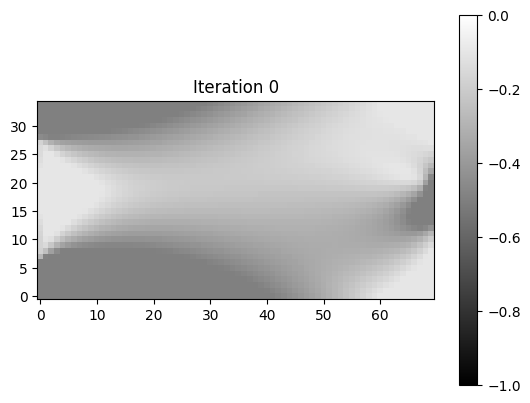

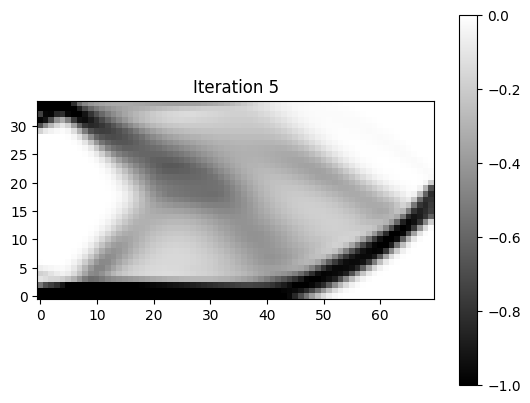

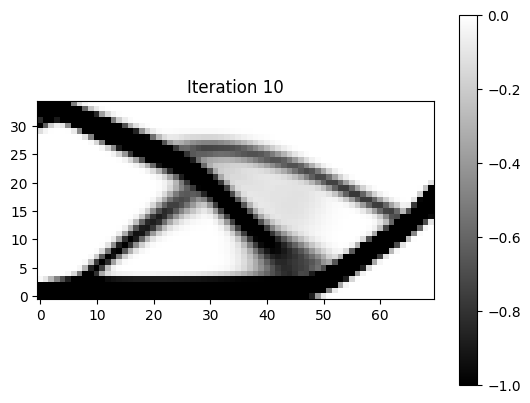

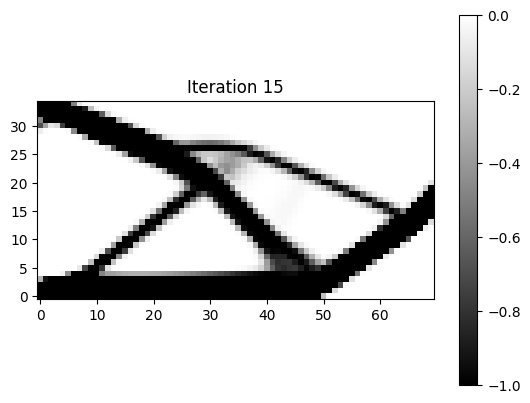

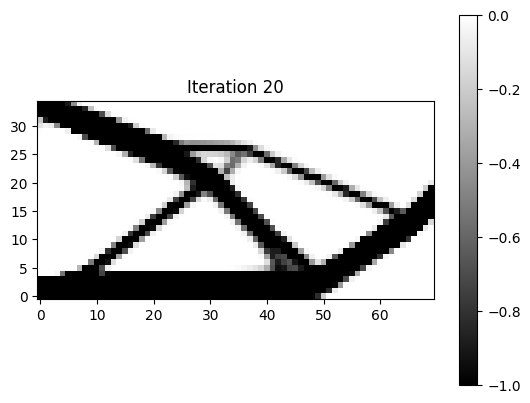

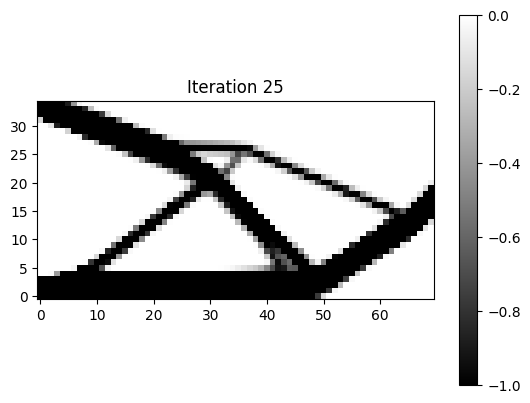

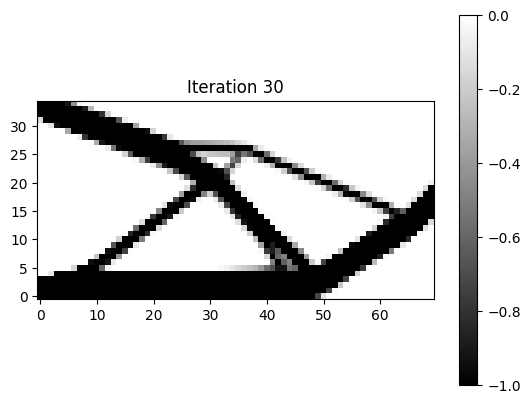

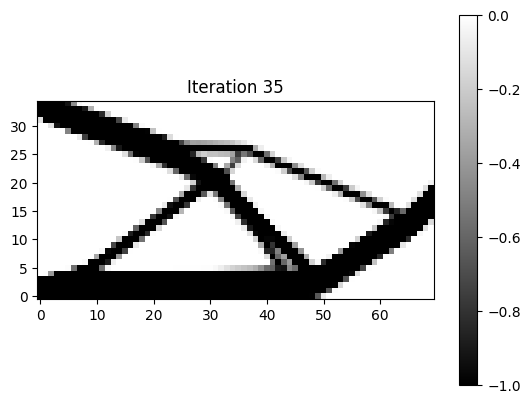

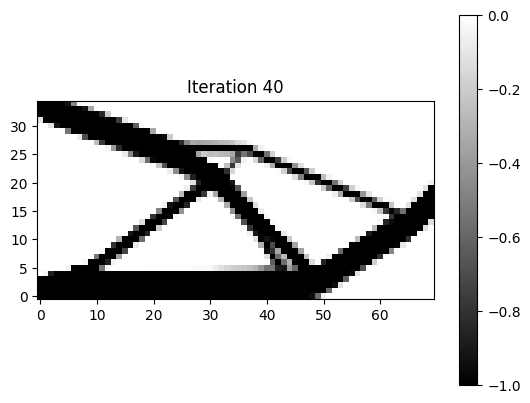

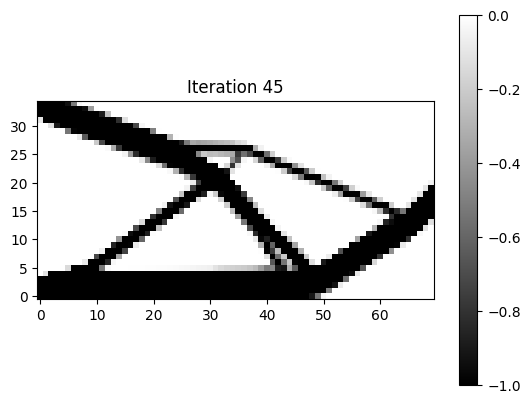

In [ ]:
# ny and nx from above
ny = p['ny']
nx = p['nx']

# Iterate over xList and display the density function every 5 iterations
for i, x in enumerate(xList):
    if i % 5 == 0:  # Check if the iteration number is a multiple of 5
        fig, ax = plt.subplots()
        # Display the density function
        im = ax.imshow(-x.reshape((ny, nx)), origin='lower', cmap='gray', interpolation='none', norm=colors.Normalize(vmin=-1, vmax=0))
        ax.set_title(f"Iteration {i}")
        plt.colorbar(im, ax=ax)  # Optional: add a colorbar
        plt.show()  # Display the plot for this iteration
plt.close()  # Close the plot to avoid redundant open figures